<a href="https://www.kaggle.com/code/mihaail/nist-conv-nn?scriptVersionId=165117001" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch 
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, TensorDataset, DataLoader 
from torchmetrics import Accuracy, MeanAbsoluteError, Precision
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
from torchvision.datasets import MNIST
import torchvision
import torchvision.transforms.v2 as T
from torch.optim.lr_scheduler import StepLR
from PIL import Image

import pandas as pd
import numpy as np

First model:
  accuracy = 0.992
  loss = 

Second model: accuracy = 0.993
loss = 

Обучение на датасете Emnist
third model: precision = 0.87


## 1. Первая и вторая модель для обучения на датасете MNIST
у этих моделей есть ошибка в том, что перед последним слоем стоит не softmax а ReLU



## 2. Третья модель 
1. Зафайнтюнить вторую модель для обучения на emnist не получилось. слишко плохое качество. precision=0.5. 

2. заменим метрику с accuracy на precision




## 3. Четвёртая модель
2. заменяется ReLU перед последним слоем на softmax




## Оценим датасет EMNIST

In [2]:
# классы
emnist_classes = {
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 
'10': ''}

### Создаем датасет и даталоадер. 

## Загружется и обрабатывается датасет EMNIST

In [3]:
# Создается класс для чтения dataset из csv файла 
class CustomDatasetEMNIST():
    def __init__(self, csv_file_path, 
                 transform=None,
                 nrows=None,
                 skiprows=None) :
        '''nrows - кол-во строк которое необходимо подгрузить,
        '''
        super().__init__()
        self.data, self.targets, self.dataframe = self._load_data(csv_file_path=csv_file_path, nrows=nrows, skiprows=skiprows)
        
        self.transform = transform
        
    def __len__(self) :
        return len(self.data) 
    
    def __getitem__(self, index) :
       
        img = self.data[index]
        #print(f'1. {img.shape=} {img}/n') 
        img = img.unsqueeze(0)
        #print(f'2.{img.shape=} {img}/n') 
        targets = int(self.targets[index])
        # Повернем и отразим изображение для лучшего восприятия
        img = torchvision.transforms.functional.rotate(img=img, angle=-90)
        img = torch.flip(img, dims=(2,))
        
        #print(f'3 {img.shape} {img} /n') 
        
        if self.transform is not None:
            #print(f'3. {img.shape} {img}') 

            img = self.transform(img)
            #print(f'4.{img.shape} {img}') 

            
        return img, targets
    
    
    def _load_data(self,
                  csv_file_path,
                  nrows,
                  skiprows=None):
        
        df = pd.read_csv(csv_file_path, nrows=nrows, skiprows=skiprows) 
        
        targets = torch.tensor(df.iloc[:,0].values)
        
        data = df.iloc[:,1:].values.reshape((len(df), 28, 28))
        
        return torch.tensor(data).float(), targets, df

## Зададим функции обучения валидации и отрисовки графиков

In [4]:
#Зададим девайс для обучения        
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(device)
try:
    print(torch.cuda.get_device_name())
except:
    print('GPU нету!')
        

    
def train(model: nn.Module,
         loader: DataLoader,
         loss_fn,
         metric) -> tuple[float, float]: 
    
    '''ф-я проводит обучение модели. 
    возвращает ошибку на трейновом датасете'''
    
    model.train()
    total_loss = 0
    total_metric = 0

    for x, y in tqdm(loader, desc="Train"):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad() 
    
        output = model(x) 
    
        loss = loss_fn(output, y) 
        total_loss += loss.item()
        
        loss.backward() 
    
        optimizer.step()
        
        total_metric +=  metric(output.detach(), y).item()
        
    total_loss /= len(loader)
    total_metric /= len(loader) 
    
    return total_loss, total_metric 


@torch.inference_mode() 
def valid(model: nn.Module,
         loader: DataLoader,
         loss_fn,
         metric) -> tuple[float, float] :
    
    '''Ф-я расчитывает ф-ю ошибки и метрику на валидационной выборке'''
    model.eval() 
    
    total_loss = 0
    total_metric = 0
    
    for x, y in tqdm(loader, desc="Evaluation"):
        x, y = x.to(device), y.to(device)
        
        output = model(x) 
        
        loss = loss_fn(output, y) 
        
        total_loss += loss.item()
        
        total_metric += metric(output, y).item() 
        
        
    total_loss /= len(loader)
    total_metric /= len(loader) 
    return total_loss, total_metric
          

def plot_stats(
    train_loss: tuple,
    valid_loss: tuple, 
    train_metric: tuple, 
    valid_metric: tuple, 
    title: str,
    metric_name: str ) :
    '''Ф-я отрисовывает ошибку и метрику на тестовой и трейновой датасетах.
    '''
    plt.figure(figsize=(8, 5))
    plt.title(f'{title} loss') 
    plt.plot(train_loss, label='Train loss') 
    plt.plot(valid_loss, label='Valid loss') 
    
    plt.legend() 
    plt.grid() 
    
    plt.figure(figsize=(8, 5))
    plt.title(f'{title} {metric_name}')
    plt.plot(train_metric, label=f'Train {metric_name}') 
    plt.plot(valid_metric, label=f'Valid {metric_name}') 
    plt.legend() 
    
    plt.grid() 
    
    plt.show() 


    
#Функция обучения и валидации на всех эпохах

def train_test_cycle(model: nn.Module,
                    num_epochs: int, 
                    loss_fn, 
                    train_loader: DataLoader, 
                    valid_loader: DataLoader,
                    metric,
                    metric_name: str,
                    title: str,
                    scheduler):
    '''Ф-я проводит для каждой эпох обучение на трейновой выборке, валидацию для валидной выборки
    и отрисовку графиков. '''
    
    train_loss_history, train_metric_history = [], []
    valid_loss_history, valid_metric_history = [], []
    
    
    for epoch in range(num_epochs): 
        train_loss, train_metric = train(model,
                          train_loader, 
                          loss_fn,
                          metric)
        
        valid_loss, valid_metric = valid(model, 
                           valid_loader, 
                           loss_fn, 
                           metric) 
        
        train_loss_history.append(train_loss) 
        valid_loss_history.append(valid_loss) 
        
        train_metric_history.append(train_metric) 
        valid_metric_history.append(valid_metric)
                
        clear_output()
        
        plot_stats(train_loss_history, 
                  valid_loss_history, 
                  train_metric_history, 
                  valid_metric_history, 
                  title,
                  metric_name) 
        
        scheduler.step() 
        print(f'Valid Loss: {valid_loss}') 
        print(f'Valid {metric_name}: {valid_metric}') 

        


cuda:0
Tesla T4


### Создаем объект нс

In [5]:
#чтобы не вычислять заново среднее и стандартное отклонение и не подгуржать датафрейм запишем эти данные как константы

'''emnist_data = CustomDatasetEMNIST(csv_file_path='/kaggle/input/emnist/emnist-byclass-train.csv', 
transform=T.Compose[T.ToImage(),
T.ToDtype(torch.float32, scale=True)])


# Зададим mean и std для нормализации входных данных
mean = (emnist_data.data/255).mean().unsqueeze(0) 
std = (emnist_data.data/255).std().unsqueeze(0) 
print(f'{mean=}') 
print(f'{std=}') '''

mean = torch.tensor([0.1736])
std = torch.tensor([0.3317])


# Зададим трансформацию для трейн и тест датасетов
train_transforms = T.Compose(
    [
        T.Resize([28, 28]),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std), 
        T.RandomAdjustSharpness(sharpness_factor=2),
        T.RandomRotation(degrees=20),
#         T.RandomZoomOut(),
       # T.RandomResizedCrop(size=(28, 28), scale=(0.5, 1.0)),
        #T.RandomPerspective()
    ]
) 

valid_transforms = T.Compose(
    [
        T.Resize([28, 28]),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
        
        
    ]
) 
# plt.figure(figsize=(3, 3))
# plt.title(f'Цифра {emnist_data[1][1]}')
# plt.imshow(emnist_data[1][0][0])

# plt.show()

#Для обучения не будем подгружать датасет. чтобы не занимать оперативную память 
'''
df = pd.read_csv('/kaggle/input/emnist/emnist-byclass-train.csv')

df.head(2)

#выведем классы изображений и запишем их кол-во
classes = df.iloc[:,0]
print(np.sort(classes.unique()))
emnist_num_classes = classes.nunique()
print(emnist_num_classes)

#Оценим распределение классов в датасете
plt.figure(figsize=(5,5))
plt.hist(classes,bins=emnist_num_classes, orientation='horizontal', alpha=0.5)
plt.show()

Как видно из графика присутствует сильный перекос в классах данных
'''
emnist_num_classes = 62

train_dataset = CustomDatasetEMNIST(csv_file_path='/kaggle/input/emnist/emnist-byclass-train.csv', 
                                    
#                                     skiprows=50000,
                                    nrows=150000, 
                                    transform=train_transforms) 

valid_dataset = CustomDatasetEMNIST(csv_file_path='/kaggle/input/emnist/emnist-byclass-test.csv',
#                                    nrows=100000, 
                                    transform=valid_transforms) 

train_loader = DataLoader(train_dataset, batch_size=1500, shuffle=True) 
valid_loader = DataLoader(valid_dataset, batch_size=1500, shuffle=True) 

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [9]:
# Создадим класс (и архитектуру) третьей модели. Для обучения на датасете EMNIST

class ThirdModel(nn.Module) :
    def __init__(self) :
        super().__init__() 
        # Размерность входного тензора: 1х28х28
       
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=3,
                      padding=1
                     ), #64x26x26
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3, 
                      padding=1) , #64x28x28
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
     
            
            nn.MaxPool2d(kernel_size=2), #64x14x14
            nn.Dropout2d(p=0.2), 
            
            nn. Conv2d(in_channels=64, 
                       out_channels=128, 
                       kernel_size=3
                       ), #64X12x12
            nn.BatchNorm2d(128), 
            
            nn.ReLU(), 
            
            nn.Conv2d(in_channels=128, 
                       out_channels=128, 
                       kernel_size=3,
                       padding=1),
            nn. BatchNorm2d(128), 
            nn.ReLU(), 
            
            nn.MaxPool2d(kernel_size=2), #128x6x6
            nn.Dropout2d(p=0.3), 
            
            nn.Conv2d(in_channels=128, 
                      out_channels=128, 
                      kernel_size=3, 
                      padding=1), #128x6x6
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, 
                      out_channels=256, 
                      kernel_size=3, 
                      padding=1), #256x6x6
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, 
                      out_channels=256, 
                      kernel_size=3, 
                      padding=1), 
            nn.BatchNorm2d(256), #256x6x6
            nn.ReLU(), 
            
            nn.MaxPool2d(kernel_size=2), #256x3x3
            nn.Dropout2d(p=0.3), 
            
            nn.Flatten(), #256x3x3
            nn.Linear(256 *3*3, 372), 
            nn.ReLU() , 
            nn.Linear(372, emnist_num_classes) , 
        )
   
    def forward(self, x) :
        return self.net(x) 

In [10]:
pip install torchsummary 

Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch
import torch.nn as nn
from torchsummary import summary 

tmodel = ThirdModel().to(device)

summary(tmodel, (1, 28, 28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          36,928
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
         MaxPool2d-7           [-1, 64, 14, 14]               0
         Dropout2d-8           [-1, 64, 14, 14]               0
            Conv2d-9          [-1, 128, 12, 12]          73,856
      BatchNorm2d-10          [-1, 128, 12, 12]             256
             ReLU-11          [-1, 128, 12, 12]               0
           Conv2d-12          [-1, 128, 12, 12]         147,584
      BatchNorm2d-13          [-1, 128, 12, 12]             256
             ReLU-14          [-1, 128,

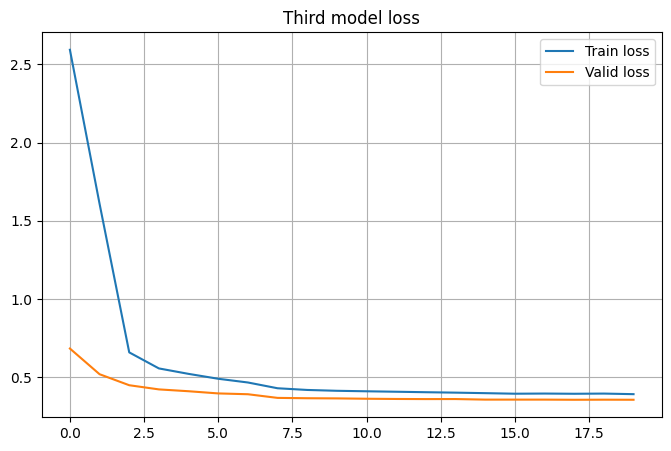

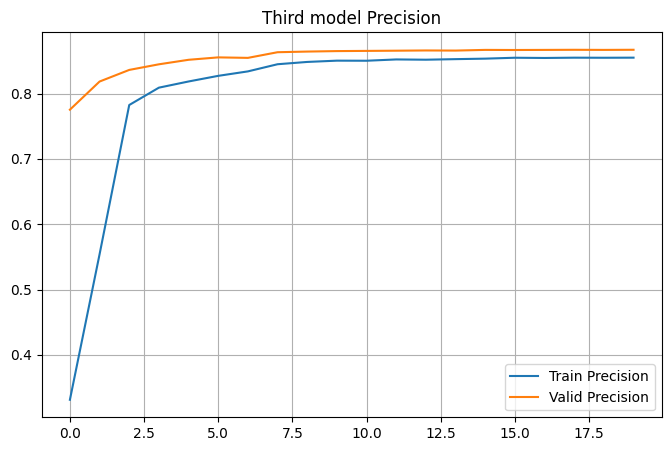

Valid Loss: 0.3564878293336966
Valid Precision: 0.8670912094605274


In [12]:
num_epochs = 20


metric = Precision(task='multiclass', num_classes=emnist_num_classes).to(device)
metric_name = 'Precision'


#model = FourthModel()
model = ThirdModel() 
#model = model.to(device)

if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        print(f'Имеется {torch.cuda.device_count()} GPU') 
        model = nn.DataParallel(model) 

model.to(device) 

title = 'Third model'

optimizer = optim.Adam(model.parameters(), lr=1e-3) 

scheduler = StepLR(optimizer, step_size=7) 

loss_fn = nn.CrossEntropyLoss()

train_test_cycle(model,
                 num_epochs,
                 loss_fn, 
                 train_loader,
                 valid_loader,
                 metric,
                 metric_name,
                 title, 
                 scheduler
                )


In [13]:
# Сохранение модели
from datetime import  date
torch.save(model.state_dict(), f'{title}_{date.today()}_2.pth')


## Четвертая модель

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary 


fmodel = FourthModel()
summary(fmodel, ( 1, 28, 28) ) 

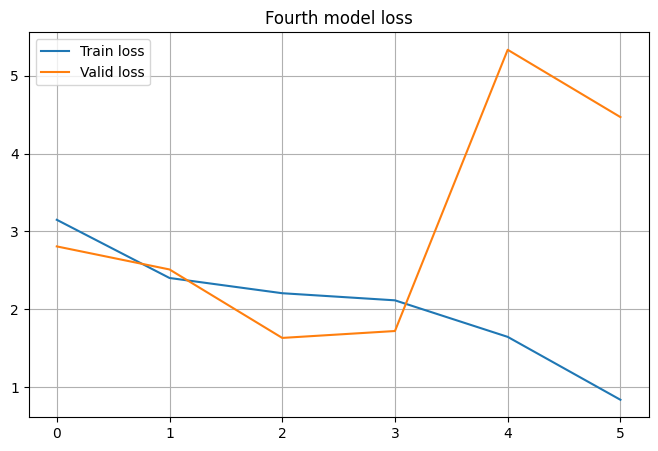

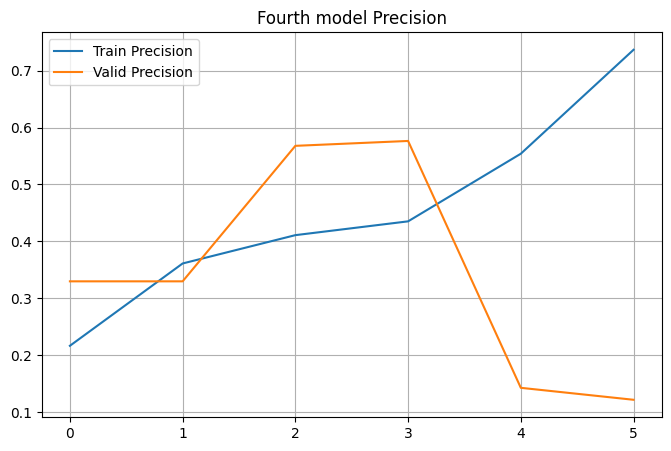

Valid Loss: 4.46967001914978
Valid Precision: 0.12149999991059303


Train:  22%|██▏       | 11/50 [00:07<00:27,  1.42it/s]


KeyboardInterrupt: 

In [17]:
num_epochs = 10


metric = Precision(task='multiclass', num_classes=emnist_num_classes).to(device)
metric_name = 'Precision'


model = FourthModel()
#model = ThirdModel() 
#model = model.to(device)

if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        print(f'Имеется {torch.cuda.device_count()} GPU') 
        model = nn.DataParallel(model) 

model.to(device) 

title = 'Fourth model'

optimizer = optim.Adam(model.parameters(), lr=1e-3) 

scheduler = StepLR(optimizer, step_size=8) 

loss_fn = nn.CrossEntropyLoss()

train_test_cycle(model,
                 num_epochs,
                 loss_fn, 
                 train_loader,
                 valid_loader,
                 metric,
                 metric_name,
                 title, 
                 scheduler
                )


In [ ]:
import torch
import torch.nn as nn
from torchviz import make_dot
# Определение архитектуры нейронной сети
#class ResidualBlock(nn.Module):
    # Определение блока Residual
    # ...
#class NeuralNetwork(nn.Module):
    # Определение нейронной сети
    # ...
# Создание экземпляра модели
#model = NeuralNetwork()
# Создание фиктивного входного тензора для визуализации
x = torch.randn( 1, 28, 28)
# Получение выходного тензора после прямого прохода
y = model(x)
# Создание графа вычислений для модели
graph = make_dot(y, params=dict(model.named_parameters()))
# Сохранение графа в файл
graph.render("neural_network_architecture", format="png")
# Отображение графа
graph.view()


In [ ]:
# Сохранение модели
torch.save(model.state_dict(), f'{title}.pth')

In [ ]:
'''
# Загрузка модели
load_model = SecondModel()
load_model.load_state_dict(torch.load(f'{title}.pth'))
load_model.eval()

''' 



In [ ]:
'''
input_object = 2
input_tensor = torch.tensor([input_object], dtype=torch.float32)
output_value = load_model(input_tensor).item()
output_value
'''

In [ ]:
#Зададим алгоритм предсказания на датасете MNIST 
'''
# классы
mnist_classes = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 9: '8', 9: '9'}

model = SecondModel()
model.load_state_dict(torch.load('/kaggle/input/emnist_model/pytorch/second_model/1/Second model.pth', map_location=torch.device('cpu')))

#Оценим качество полученной модели
mnist_dataset = MNIST(root= "../datasets/mnist", train=False, download=True, transform=T.ToTensor())

item_num = 4
plt.figure(figsize=(3, 3))
plt.title(f'Цифра {mnist_dataset[item_num][1]}')
plt.imshow(mnist_dataset[item_num][0][0])

plt.show()



print(model(mnist_dataset[item_num][0].unsqueeze(0)))

# определим вектор вероятностей предсказания классов
result_probab = model(mnist_dataset[item_num][0].unsqueeze(0))[0].detach().numpy()

# выведем индекс класса с максимальной вероятностью
im_class = result_probab.argmax()
print(im_class)

# из словаря выведем Название цифры по типу
number = mnist_classes[im_class]
print(f'На изображении цифра: {number}')
'''